# Overview
Since making all the predictions takes a long time and quite a bit of memory, we make a seperate kernel for just the submission, where we read the test data and apply the model. The model is built and trained in the kernel at https://www.kaggle.com/kmader/baseline-u-net-model-part-1

In [ ]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
#from skimage.util.montage import montage2d as montage

In [ ]:
path = "/mnt/3CE35B99003D727B/input/kaggle/Airbus Ship Detection Challenge/"

In [3]:
masks = pd.read_csv(os.path.join(path + 'train_ship_segmentations_v2.csv'))

In [4]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.util import montage2d as montage
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ship_dir = path
train_image_dir = os.path.join(ship_dir, 'train_v2')
test_image_dir = os.path.join(ship_dir, 'test_v2')
import gc; gc.enable() # memory is tight

from skimage.morphology import label
def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

In [5]:
from keras import models, layers
fullres_model = models.load_model('fullres_model.h5', compile=False)
seg_in_shape = fullres_model.get_input_shape_at(0)[1:3]
seg_out_shape = fullres_model.get_output_shape_at(0)[1:3]
print(seg_in_shape, '->', seg_out_shape)

Using TensorFlow backend.
/home/jake/venv/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jake/venv/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jake/venv/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jake/venv/lib/python3.7/site-packages/tensorboard/

(None, None) -> (None, None)


# Load Test Data¶

In [6]:
test_paths = os.listdir(test_image_dir)
print(len(test_paths), 'test images found')

15606 test images found


CPU times: user 2.59 s, sys: 418 ms, total: 3.01 s
Wall time: 3.05 s


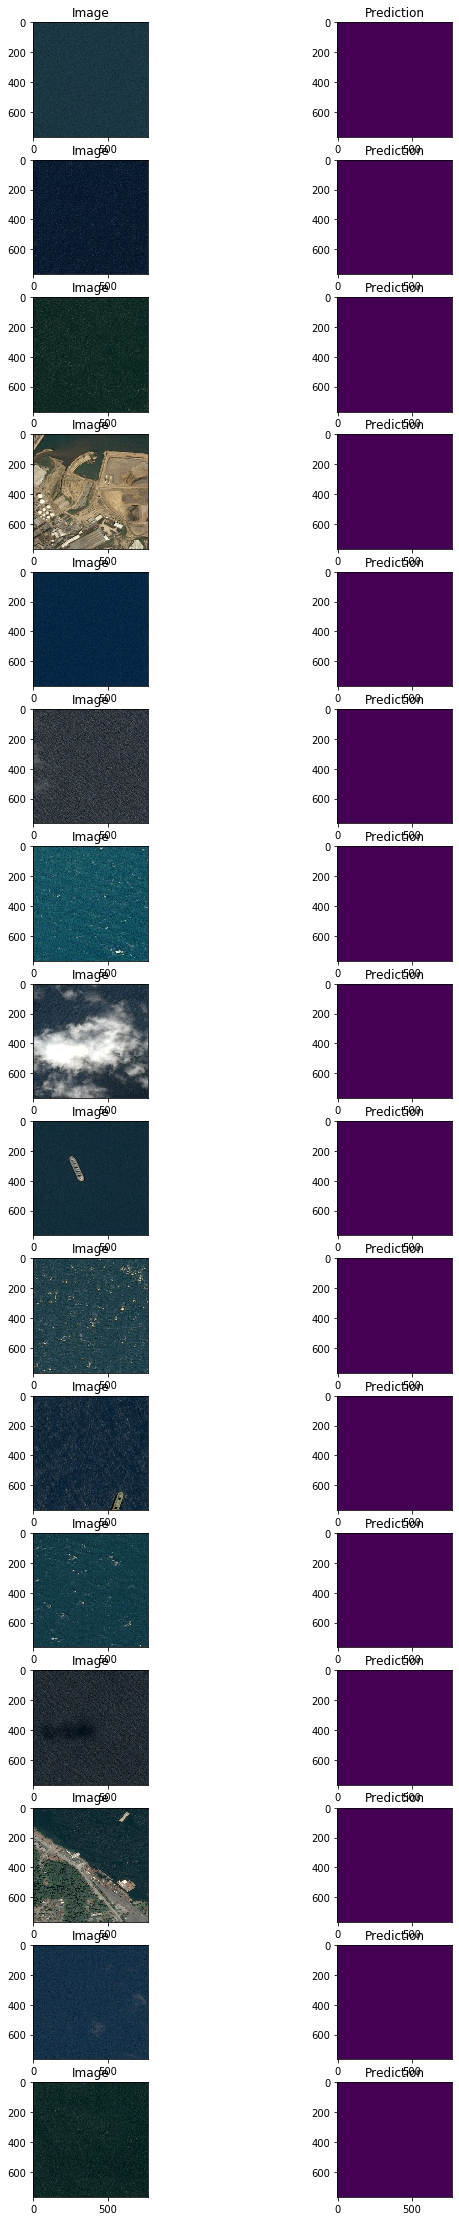

In [7]:
%%time
fig, m_axs = plt.subplots(16, 2, figsize = (10, 40))
for (ax1, ax2), c_img_name in zip(m_axs, test_paths):
    c_path = os.path.join(test_image_dir, c_img_name)
    c_img = imread(c_path)
    first_img = np.expand_dims(c_img, 0)/255.0
    first_seg = fullres_model.predict(first_img)
    ax1.imshow(first_img[0])
    ax1.set_title('Image')
    ax2.imshow(first_seg[0, :, :, 0], vmin = 0, vmax = 1)
    ax2.set_title('Prediction')
fig.savefig('test_predictions.png')

# Create Submission¶
Here we run the analysis on all of the images and prepare the submission.

In [8]:
%%time
from tqdm import tqdm_notebook
from skimage.morphology import binary_opening, disk
out_pred_rows = []
for c_img_name in tqdm_notebook(test_paths):
    c_path = os.path.join(test_image_dir, c_img_name)
    c_img = imread(c_path)
    c_img = np.expand_dims(c_img, 0)/255.0
    cur_seg = fullres_model.predict(c_img)[0]
    cur_seg = binary_opening(cur_seg>0.5, np.expand_dims(disk(2), -1))
    cur_rles = multi_rle_encode(cur_seg)
    if len(cur_rles)>0:
        for c_rle in cur_rles:
            out_pred_rows += [{'ImageId': c_img_name, 'EncodedPixels': c_rle}]
    else:
        out_pred_rows += [{'ImageId': c_img_name, 'EncodedPixels': None}]
    gc.collect()

/home/jake/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



CPU times: user 36min 5s, sys: 43.1 s, total: 36min 48s
Wall time: 40min 1s


In [37]:
out_pred_rows[0]

{'ImageId': '00002bd58.jpg', 'EncodedPixels': None}

In [9]:
submission_df = pd.DataFrame(out_pred_rows)[['ImageId', 'EncodedPixels']]
submission_df.to_csv('submission.csv', index=False)
submission_df.sample(3)

,ImageId,EncodedPixels
9500,f378ddd46.jpg,None
15163,d9b1a789a.jpg,None
9222,70d703627.jpg,None


In [41]:
submission_df[submission_df['EncodedPixels']==None]

,ImageId,EncodedPixels


# Show the ships we found¶
Here we can see the number of ships found per image

In [11]:
submission_df['counts'] = submission_df.apply(lambda c_row: c_row['counts'] if 
                                    isinstance(c_row['EncodedPixels'], str) else
                                    0, 1)
submission_df['counts'].hist()

KeyError: ('counts', 'occurred at index 2')